In [0]:
import networkx as nx
import collections
import matplotlib.pylab as plt
import numpy as np
import scipy

In [0]:
# sampling a preferential attachment graph with n nodes and m degree the way
# the paper does it
def sample_pa(n, m):
    if m < 1 or  m >=n:
        raise nx.NetworkXError(\
              "Barabási-Albert network must have m>=1 and m<n, m=%d,n=%d"%(m,n))

    # Start with one node with m self-edges
    G = nx.Graph()
    G.add_node(0)
    G.add_edges_from(zip([0]*m, [0]*m))
    
    # a list of vertices, repeated for how large their degree is
    repeated_nodes = [0]*m
    targets = repeated_nodes
    # the new node to be added
    source = 1
    while source < n:
      # add edges to m nodes from the source
      G.add_edges_from(zip([source]*m, targets))
      # add the connected edges to the list
      repeated_nodes.extend(targets)
      # add the new node "source" to the list
      repeated_nodes.extend([source]*m)
      # choose m nodes 
      targets = np.random.choice(repeated_nodes, m)
      source += 1
    
    return G

In [0]:
# last bin is the youngest
# the peeling algorithm
def peeling(H):
  bins = []
  G = H.copy()
  while G.order() > 0:
    currbin = []
    minDeg = min(list(G.degree(G)), key = lambda x : x[1])[1]
    currlist = list(G.nodes())
    for n in currlist:
      if G.degree(n) == minDeg:
        currbin.append(n)
    G.remove_nodes_from(currbin)
    bins.append(currbin)
  return bins       
          
       

In [0]:
# make a dictionary from vertex id to bin
def vertexToBin(bins):
  vToBin = collections.defaultdict()
  for i, currbin in enumerate(bins):
    for j in currbin:
      vToBin[j] = i
  return vToBin
      

In [0]:
# remember: indexing begins at 0
# for a graph G and a bin i, tally frequencies for how many bins up edges are going
def distribution(G, i):
  bins = peeling(G)
  vToBin = vertexToBin(bins)
  cnt = collections.Counter()
  for n in bins[i]:
    currneighbors = list(G.neighbors(n))
    for k in currneighbors:
      if vToBin[k] - i < 0:
        continue
      cnt[vToBin[k] - i] += 1
  return cnt

In [0]:
# take a list of lists and take an average at each index, outputting an array with the length of the longest list in the list of lists
def customMean(ll):
    maxlength = max(map(len, ll))
    res = np.zeros(maxlength)
    resdiv = np.zeros(maxlength)
    for l in ll:
      for j, val in enumerate(l):
        res[j] += val
        resdiv[j] += 1
    for i in range(maxlength):
      res[i] = res[i]/resdiv[i]
    return res

In [0]:
# take edges distributions from multiple graphs at the same bin and use the averaging function above, graph
def graphDist(n, m, i, samples):
  maxlength = 0
  ylists = []
  for t in range(0, samples):    
    G = nx.barabasi_albert_graph(n, m)
    lists = sorted(distribution(G, i).items())
    x, y = zip(*lists)
    x = list(x)
    y = list(y)
    if maxlength < len(x):
      maxlength = len(x)
    ylists.append(y)
  xfinal = np.arange(maxlength) + 1 
  mappedy = list(map(lambda y: np.array(y), ylists))
  yfinal = list(customMean(mappedy))
  
  plt.plot(xfinal, np.log(yfinal))
  plt.show()
  return np.array(xfinal), np.array(yfinal)

In [0]:
# same as above, but using the custom PA algorithm
def loopGraphDist(n, m, i, samples):
  maxlength = 0
  ylists = []
  for t in range(0, samples):    
    G = sample_pa(n, m)
    lists = sorted(distribution(G, i).items())
    x, y = zip(*lists)
    x = list(x)
    y = list(y)
    if maxlength < len(x):
      maxlength = len(x)
    ylists.append(y)
  xfinal = np.arange(maxlength) + 1 
  mappedy = list(map(lambda y: np.array(y), ylists))
  yfinal = list(customMean(mappedy))
  
  plt.plot(xfinal, np.log(yfinal))
  plt.show()
  return np.array(xfinal), np.array(yfinal)

In [0]:
# calculates the measures of quality on how peeling performs on a particular graph 
# output: number correct, number of guesses, precision, recall, density
def measures(G):
  # bins of vertex ids
  bins = peeling(G)
  correct = 0
  guesses = 0
  for i in range(0, len(bins)):
    for j in range(i + 1, len(bins)):
      # number of guesses is the products of the lengths of all pairs of bins
      guesses = guesses + len(bins[i])*len(bins[j])
      for k in bins[i]:
        for l in bins[j]:
          # youngest bins are in the later bins
          if k > l:
            correct = correct + 1
  return correct, guesses, correct/guesses, correct/scipy.misc.comb(G.order(), 2), guesses/scipy.misc.comb(G.order(), 2)
  
      

In [6]:
customCorrect = 0
customGuessed = 0
defaultCorrect = 0
defaultGuessed = 0
for i in range(0, 100):
  correct, guessed, _, _, _ = measures(sample_pa(5000,5))
  
  customCorrect += correct
  customGuessed += guessed
  
  correct, guessed, _, _, _ = measures(nx.barabasi_albert_graph(5000,5))
  defaultCorrect += correct
  defaultGuessed += guessed

print(customCorrect/100, customGuessed/100, defaultCorrect/100, defaultGuessed/100)
print((customCorrect/100)/scipy.misc.comb(G.order(), 2), (customGuessed/100)/correct/scipy.misc.comb(G.order(), 2))

9446601.47 10797462.38 9499500.1 10808043.2


In [8]:
print((customCorrect/100)/scipy.misc.comb(5000, 2), (customGuessed/100)/scipy.misc.comb(5000, 2))
print((defaultCorrect/100)/scipy.misc.comb(5000, 2), (defaultGuessed/100)/scipy.misc.comb(5000, 2))


0.7558792934586918 0.8639697843568714
0.7601120304060812 0.8648164192838567


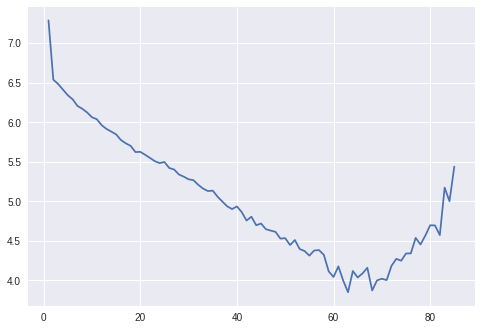

6.158171177794981
-0.026660810142139522
-0.8566989536410683


In [13]:
x,y = graphDist(10000, 10, 0, 50)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, np.log(y))
print(intercept)
print(slope)
print(r_value)

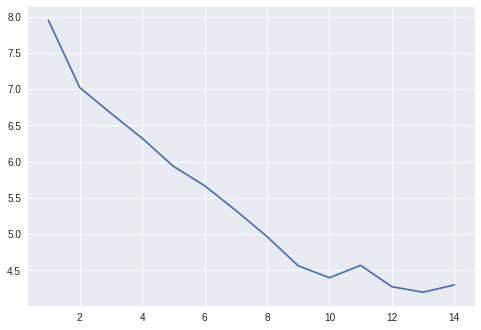

7.477855838590722
-0.27174543012548985
-0.9550329309589725


In [0]:
x,y = graphDist(10000, 1, 0, 50)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, np.log(y))
print(intercept)
print(slope)
print(r_value)

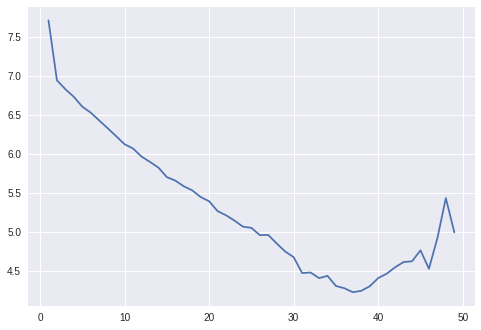

6.8833917439629095
-0.07452743845856728
-0.9971878298092204


In [0]:
x,y = graphDist(10000, 5, 0, 50)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[5:30], np.log(y[5:30]))
print(intercept)
print(slope)
print(r_value)

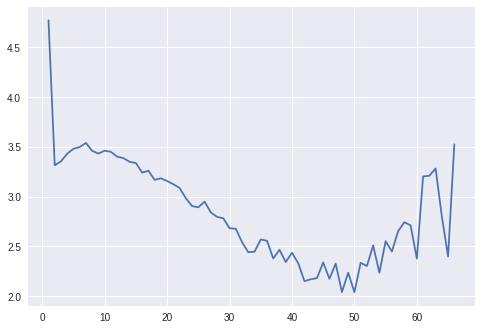

3.4410844141395716
-0.01774861953000425
-0.6543285916177725


In [0]:
x,y = graphDist(10000, 10, 20, 50)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, np.log(y))
print(intercept)
print(slope)
print(r_value)

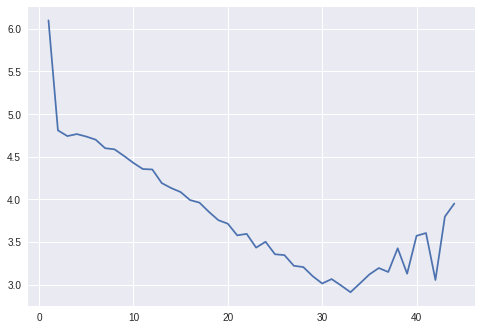

5.138028128475118
-0.07101482814417973
-0.9966751023119157


In [0]:
x,y = graphDist(10000, 5, 5, 50)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[5:20], np.log(y[5:20]))
print(intercept)
print(slope)
print(r_value)